In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mc90v-full/M2508_train_sensors.csv
/kaggle/input/mc90v-full/M2508_test_sensors.csv
/kaggle/input/mc90v-full/M2508_train_full.csv
/kaggle/input/mc90v-full/M2503_test_full.csv
/kaggle/input/mc90v-full/M2503_train_full.csv
/kaggle/input/mc90v-full/M0000_test_sensors.csv
/kaggle/input/mc90v-full/M2503_train_sensors.csv
/kaggle/input/mc90v-full/M2506_test_full.csv
/kaggle/input/mc90v-full/M0000_train_full.csv
/kaggle/input/mc90v-full/M0000_test_full.csv
/kaggle/input/mc90v-full/M2506_train_sensors.csv
/kaggle/input/mc90v-full/M2506_train_full.csv
/kaggle/input/mc90v-full/M2503_test_sensors.csv
/kaggle/input/mc90v-full/M0000_train_sensors.csv
/kaggle/input/mc90v-full/M2506_test_sensors.csv
/kaggle/input/mc90v-full/M2508_test_full.csv


#### Reading Data

In [22]:
m0000_train = pd.read_csv('/kaggle/input/mc90v-full/M0000_train_sensors.csv')
m0000_test = pd.read_csv('/kaggle/input/mc90v-full/M0000_test_sensors.csv')
m2503_train = pd.read_csv('/kaggle/input/mc90v-full/M2503_train_sensors.csv')
m2503_test = pd.read_csv('/kaggle/input/mc90v-full/M2503_test_sensors.csv')
m2506_train = pd.read_csv('/kaggle/input/mc90v-full/M2506_train_sensors.csv')
m2506_test = pd.read_csv('/kaggle/input/mc90v-full/M2506_test_sensors.csv')
m2508_train = pd.read_csv('/kaggle/input/mc90v-full/M2508_train_sensors.csv')
m2508_test = pd.read_csv('/kaggle/input/mc90v-full/M2508_test_sensors.csv')

#### Preprocessing

In [23]:
def fault_filler(df):
    idx = int(df.shape[0] * 0.05)
    df = df.iloc[idx:,:]
    df = df.interpolate().fillna(df.mean())
    return df

def filler(df):
    df = df.iloc[0:,:]
    df = df.interpolate().fillna(df.mean())
    
    return df 

def one_hot_encoder(df):
    df_encoded = pd.get_dummies(df[['Load', 'SeaTemp', 'WindSpeed']])
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(['Load','SeaTemp','WindSpeed','Time'],axis=1)
    return df 

In [24]:
m0000_train_filled = m0000_train.groupby(['RunId','Load']).apply(filler)
m0000_train = one_hot_encoder(m0000_train_filled)
m0000_test_filled = m0000_test.groupby(['RunId','Load']).apply(filler)
m0000_test = one_hot_encoder(m0000_test_filled)

m2503_train_filled = m2503_train.groupby(['RunId','Load']).apply(fault_filler)
m2503_train = one_hot_encoder(m2503_train_filled)
m2503_test_filled = m2503_test.groupby(['RunId','Load']).apply(fault_filler)
m2503_test = one_hot_encoder(m2503_test_filled)

m2506_train_filled = m2506_train.groupby(['RunId','Load']).apply(fault_filler)
m2506_train = one_hot_encoder(m2506_train_filled)
m2506_test_filled = m2506_test.groupby(['RunId','Load']).apply(fault_filler)
m2506_test = one_hot_encoder(m2506_test_filled)

m2508_train_filled = m2508_train.groupby(['RunId','Load']).apply(fault_filler)
m2508_train = one_hot_encoder(m2508_train_filled)
m2508_test_filled = m2508_test.groupby(['RunId','Load']).apply(fault_filler)
m2508_test = one_hot_encoder(m2508_test_filled)

In [25]:
print(str(m0000_train.shape[0]) +"  " + str(m0000_test.shape[0]))
print(str(m2503_train.shape[0]) +"  " + str(m2503_test.shape[0]))
print(str(m2506_train.shape[0]) +"  " + str(m2506_test.shape[0]))
print(str(m2508_train.shape[0]) +"  " + str(m2508_test.shape[0]))

778860  402493
724121  373372
606457  312379
671093  344968


In [26]:
m2503_train = m2503_train.drop('RunId',axis=1).reset_index().set_index('level_2').drop('Load',axis=1)
m2503_test  = m2503_test.drop('RunId',axis=1).reset_index().set_index('level_2').drop('Load',axis=1)
m2506_train = m2506_train.drop('RunId',axis=1).reset_index().set_index('level_2').drop('Load',axis=1)
m2506_test  = m2506_test.drop('RunId',axis=1).reset_index().set_index('level_2').drop('Load',axis=1)
m2508_train = m2508_train.drop('RunId',axis=1).reset_index().set_index('level_2').drop('Load',axis=1)
m2508_test  = m2508_test.drop('RunId',axis=1).reset_index().set_index('level_2').drop('Load',axis=1)

#### Target

In [27]:
# 0-> M0000
# 3-> M2503
# 6-> M2506
# 8-> M2508

faults = {0:0, 3:1, 6:2, 8:3}
m0000_train['fault_class'] = faults[0]
m0000_test['fault_class'] = faults[0]

m2503_train['fault_class'] = faults[3]
m2503_test['fault_class'] = faults[3]

m2506_train['fault_class'] = faults[6]
m2506_test['fault_class'] = faults[6]

m2508_train['fault_class'] = faults[8]
m2508_test['fault_class'] = faults[8]

### Merge Dataset

In [29]:
X_train = pd.concat([m0000_train, m2503_train, m2506_train, m2508_train])
X_test  = pd.concat([m0000_test,  m2503_test,  m2506_test,  m2508_test])

y_train = X_train['fault_class']
y_test  = X_test['fault_class']

X_train = X_train.drop('fault_class',axis=1)
X_test = X_test.drop('fault_class',axis=1)


In [31]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
706371    3
706372    3
706373    3
706374    3
706375    3
Name: fault_class, Length: 2780531, dtype: int64

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

num_classes = 4

### Model

In [35]:
model = Sequential([
    LSTM(64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])

In [36]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=30, batch_size=64, validation_data=(X_test_scaled, y_test))

Epoch 1/30
43446/43446 [==============================] - 268s 6ms/step - loss: 0.1180 - accuracy: 0.9426 - val_loss: 0.1114 - val_accuracy: 0.9455
Epoch 2/30
43446/43446 [==============================] - 264s 6ms/step - loss: 0.0997 - accuracy: 0.9497 - val_loss: 0.1183 - val_accuracy: 0.9443
Epoch 3/30
43446/43446 [==============================] - 272s 6ms/step - loss: 0.0949 - accuracy: 0.9521 - val_loss: 0.1268 - val_accuracy: 0.9462
Epoch 4/30
43446/43446 [==============================] - 278s 6ms/step - loss: 0.0912 - accuracy: 0.9544 - val_loss: 0.1318 - val_accuracy: 0.9451
Epoch 5/30
43446/43446 [==============================] - 265s 6ms/step - loss: 0.0880 - accuracy: 0.9565 - val_loss: 0.1467 - val_accuracy: 0.9444
Epoch 6/30
43446/43446 [==============================] - 246s 6ms/step - loss: 0.0852 - accuracy: 0.9585 - val_loss: 0.1666 - val_accuracy: 0.9453
Epoch 7/30
43446/43446 [==============================] - 232s 5ms/step - loss: 0.0827 - accuracy: 0.9600 - val_

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 64)             30464     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 43,476
Trainable params: 43,476
Non-trainable params: 0
_________________________________________________________________


In [38]:
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

44788/44788 [==============================] - 100s 2ms/step


In [39]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print(f'Test Accuracy: {accuracy}')
print(f'Weighted Precision: {precision}')
print(f'Weighted Recall: {recall}')
print(f'Weighted F1 Score: {f1}')

Test Accuracy: 0.9410464048584578
Weighted Precision: 0.9412870729436534
Weighted Recall: 0.9410464048584578
Weighted F1 Score: 0.9410891022141259


### Results

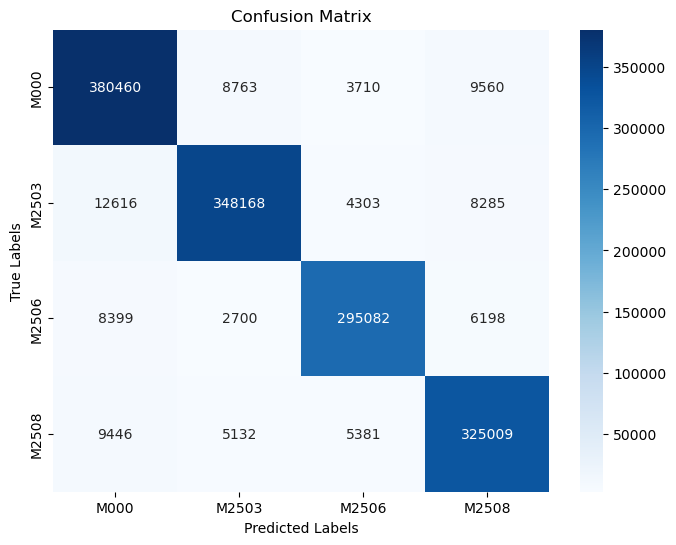

In [40]:
c_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
labels = ["M000","M2503","M2506","M2508"]
sns.heatmap(c_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()